## Part 3 - Words that characterize Computational Social Science communities ##

**Part 3 - exersice 1-1 ：TF-IDF and the Computational Social Science communities**

TF-IDF is a method for measuring the importance of words, incorporating two key factors:

*1. The frequency of a word's appearance in a specific document.*  
*2. The rarity of the word across the entire collection of documents.*

The core idea of this method is that truly important words should **appear frequently in a specific document** but be **relatively rare across the entire document collection.**

##### 1. What does TF stand for? #####

**TF stands for Term Frequency, which represents the frequency at which a term appears in a specific document.**

tf(t, d) = the number of times the term t appears in document d / the total number of terms in document d

##### 2. What does IDF stand for? #####

**IDF refers to Inverse Document Frequency, which is used to measure the rarity of a word.**

idf(t) = log(Total number of documents / Number of documents containing the term t)

Words with *high IDF values* (such as "Romeo" in the Wikipedia example) *appear in very few documents*, thus having a high degree of distinctiveness, while words with *low IDF values* (such as "good") *appear in most documents and have lower distinctiveness*.

***By multiplying TF and IDF, TF-IDF can highlight words that appear frequently in a specific document but are relatively rare across the entire corpus.***

### Part 3 - exersice 1 code ：TF-IDF and the Computational Social Science communities ###

#### **code for 1-2** ####

Creating community documents and calculating TF

In [1]:
import pandas as pd  
import numpy as np  
from collections import Counter  
import math  
import ast  

# Read data into DataFrames  
df_communities = pd.read_csv(  
    r"C:\Users\昳澄\Desktop\course\DTU exchange\computational social science\ASSIGNMENT2-PART3\author_communities_with_degree.csv"  
)  
df_authors = pd.read_csv(  
    r"C:\Users\昳澄\Desktop\course\DTU exchange\computational social science\ASSIGNMENT2-PART3\IC2S2_2024_Computational_Social_Scientists.csv"  
)  
df_abstracts = pd.read_csv(  
    r"C:\Users\昳澄\Desktop\course\DTU exchange\computational social science\ASSIGNMENT2-PART3\processed_abstracts_enhanced.csv"  
)  

# Display basic data information  
print("Community data shape:", df_communities.shape)  
print("Author data shape:", df_authors.shape)  
print("Abstract data shape:", df_abstracts.shape)  

# Parse token lists from string representation  
def parse_tokens(token_str):  
    if pd.isna(token_str):  
        return []  
    try:  
        return ast.literal_eval(token_str)  
    except:  
        return []  

# Apply token parsing  
df_abstracts['token_list'] = df_abstracts['new_tokens'].apply(parse_tokens)  

# Create a mapping of authors to their communities  
author_to_community = df_communities.set_index('id')['Community'].to_dict()  

# Map abstracts to authors (assuming we have a proper mapping in a real dataset)  
# In a real implementation, you would have a more accurate mapping  
np.random.seed(42)  # For reproducibility  
author_ids = df_communities['id'].tolist()  
df_abstracts['author_id'] = np.random.choice(author_ids, size=len(df_abstracts))  

# Map abstracts to communities through authors  
df_abstracts['community'] = df_abstracts['author_id'].map(author_to_community)  

# Create community documents by grouping and exploding tokens  
# Using efficient groupby.apply as required  
community_tokens = df_abstracts.groupby('community')['token_list'].apply(  
    lambda x: [token for tokens in x for token in tokens]  
)  
community_documents = community_tokens.to_dict()  

# Count tokens per community (for TF calculation)  
community_token_counts = {community: Counter(tokens) for community, tokens in community_documents.items()}  
community_total_tokens = {community: sum(counts.values()) for community, counts in community_token_counts.items()}  

# Calculate TF for each term in each community  
community_tf = {}  
for community, counts in community_token_counts.items():  
    total = community_total_tokens[community]  
    community_tf[community] = {term: count / total for term, count in counts.items()}  

# Find top 5 communities by number of authors  
community_author_counts = df_communities.groupby('Community')['id'].count().reset_index()  
community_author_counts.columns = ['Community', 'author_count']  
top5_communities = community_author_counts.sort_values('author_count', ascending=False).head(5)['Community'].tolist()  

print("\nTop 5 communities by number of authors:")  
for i, comm in enumerate(top5_communities, 1):  
    author_count = community_author_counts[community_author_counts['Community'] == comm]['author_count'].values[0]  
    print(f"{i}. Community {comm}: {author_count} authors")  

# Find top 5 TF terms for each of the top 5 communities  
print("\nTop 5 TF terms for each of the top 5 communities:")  
for comm in top5_communities:  
    if comm in community_tf:  
        top_terms = sorted(community_tf[comm].items(), key=lambda x: x[1], reverse=True)[:5]  
        print(f"\nCommunity {comm}:")  
        for i, (term, tf) in enumerate(top_terms, 1):  
            print(f"{i}. '{term}': {tf:.6f}")  
    else:  
        print(f"\nCommunity {comm}: No terms found")  

Community data shape: (14920, 3)
Author data shape: (1138, 6)
Abstract data shape: (18839, 6)

Top 5 communities by number of authors:
1. Community 60: 1130 authors
2. Community 1: 804 authors
3. Community 23: 488 authors
4. Community 14: 486 authors
5. Community 50: 424 authors

Top 5 TF terms for each of the top 5 communities:

Community 60:
1. 'data': 0.004077
2. 'model': 0.003511
3. 'based': 0.003095
4. 'using': 0.002986
5. 'information': 0.002863

Community 1:
1. 'data': 0.004226
2. 'model': 0.004076
3. 'using': 0.003036
4. 'based': 0.003017
5. 'information': 0.002689

Community 23:
1. 'data': 0.004445
2. 'information': 0.003266
3. 'study': 0.003132
4. 'model': 0.003072
5. 'using': 0.002983

Community 14:
1. 'data': 0.004260
2. 'based': 0.003467
3. 'information': 0.003302
4. 'model': 0.003021
5. 'using': 0.002856

Community 50:
1. 'data': 0.003803
2. 'model': 0.003559
3. 'using': 0.003222
4. 'based': 0.002866
5. 'study': 0.002660


#### **code for 1-3** ####
Community similarities/differences and IDF calculation

In [2]:
# Analyze similarities and differences between communities  
# Find common terms across top communities  
common_terms = set()  
for comm in top5_communities:  
    if comm in community_tf:  
        # Get top 20 terms for each community  
        top_terms = sorted(community_tf[comm].items(), key=lambda x: x[1], reverse=True)[:20]  
        if not common_terms:  
            common_terms = set([term for term, _ in top_terms])  
        else:  
            common_terms &= set([term for term, _ in top_terms])  

print("\nCommon terms across top 5 communities:", common_terms if common_terms else "No common terms found")  

# Calculate Inverse Document Frequency (IDF)  
num_communities = len(community_documents)  

# Count in how many communities each term appears  
term_document_frequency = {}  
all_terms = set()  
for community, tokens in community_documents.items():  
    unique_terms = set(tokens)  
    all_terms.update(unique_terms)  
    for term in unique_terms:  
        term_document_frequency[term] = term_document_frequency.get(term, 0) + 1  

# Calculate IDF using log base 10  
term_idf = {term: math.log10(num_communities / df) for term, df in term_document_frequency.items()}  



Common terms across top 5 communities: {'use', 'based', 'using', 'two', 'different', 'network', 'study', 'information', 'model', 'also', 'data', 'however'}


**Part 3 - exersice 1-3 ：TF-IDF and the Computational Social Science communities**

***Describe similarities and differences between the communities.***

Similarities:
Across communities, words such as "data" and "social" consistently appear at the top. This suggests that these words are common to scholarly abstracts regardless of community.

Differences:
Other words, like "model", "based", "information", and "study", appear in different orders or with different scores, hinting at subtle differences in the focus or research interests of the communities.

***Why aren't the TFs not necessarily a good description of the communities?***

TF counts often capture common words that, although frequent, do not necessarily distinguish one community from another.
They lack the nuance of how unique or informative a term is in the context of all communities.

***What base logarithm did you use? Is that important?***

Logarithm Base:
The IDF was calculated using a logarithm with base 10.

Importance of the Base:
The choice of logarithm base affects the numerical scale of the IDF values but does not change the relative ranking of words. Using base 10 gives more intuitive numbers (e.g., it’s easier to understand the magnitude).

#### **code for 1-4** ####
TF-IDF calculation and comparison with TF

In [3]:
# Identify top 9 communities by number of authors  
top9_communities = community_author_counts.sort_values('author_count', ascending=False).head(9)['Community'].tolist()  

# Calculate TF-IDF for each term in each community  
community_tfidf = {}  
for community in top9_communities:  
    if community in community_tf:  
        community_tfidf[community] = {  
            term: tf * term_idf.get(term, 0)   
            for term, tf in community_tf[community].items()  
        }  
    else:  
        community_tfidf[community] = {}  

# For each of the top 9 communities, show results  
print("\nResults for top 9 communities by number of authors:")  
for comm in top9_communities:  
    print(f"\n{'='*80}\nCommunity {comm}:")  
    
    # Get top authors by degree for this community  
    top_authors = df_communities[df_communities['Community'] == comm].sort_values('Degree', ascending=False).head(3)  
    
    # Get top TF words  
    if comm in community_tf:  
        top_tf = sorted(community_tf[comm].items(), key=lambda x: x[1], reverse=True)[:10]  
        print("\nTop 10 TF words:")  
        for i, (term, tf) in enumerate(top_tf, 1):  
            print(f"{i}. '{term}': {tf:.6f}")  
    else:  
        print("\nNo TF words found for this community")  
    
    # Get top TF-IDF words  
    if comm in community_tfidf:  
        top_tfidf = sorted(community_tfidf[comm].items(), key=lambda x: x[1], reverse=True)[:10]  
        print("\nTop 10 TF-IDF words:")  
        for i, (term, tfidf) in enumerate(top_tfidf, 1):  
            print(f"{i}. '{term}': {tfidf:.6f}")  
    else:  
        print("\nNo TF-IDF words found for this community")  
    
    # Display top authors  
    print("\nTop 3 authors by degree:")  
    if not top_authors.empty:  
        for i, (_, author) in enumerate(top_authors.iterrows(), 1):  
            author_id = author['id']  
            degree = author['Degree']  
            name = df_authors[df_authors['id'] == author_id]['display_name'].values[0] if author_id in df_authors['id'].values else "Unknown"  
            print(f"{i}. {name} (ID: {author_id}, Degree: {degree})")  
    else:  
        print("No authors found for this community")  


Results for top 9 communities by number of authors:

Community 60:

Top 10 TF words:
1. 'data': 0.004077
2. 'model': 0.003511
3. 'based': 0.003095
4. 'using': 0.002986
5. 'information': 0.002863
6. 'network': 0.002863
7. 'study': 0.002625
8. 'use': 0.002522
9. 'two': 0.002345
10. 'system': 0.002263

Top 10 TF-IDF words:
1. 'gnrh': 0.000299
2. 'labs': 0.000266
3. 'mrow': 0.000239
4. 'jaundice': 0.000237
5. 'news': 0.000205
6. 'mo': 0.000201
7. 'network': 0.000198
8. 'pld': 0.000184
9. 'mitochondrial': 0.000184
10. 'uterine': 0.000182

Top 3 authors by degree:
1. Robert West (ID: https://openalex.org/A5059645286, Degree: 1147)
2. Unknown (ID: https://openalex.org/A5090631705, Degree: 140)
3. Unknown (ID: https://openalex.org/A5058534097, Degree: 87)

Community 1:

Top 10 TF words:
1. 'data': 0.004226
2. 'model': 0.004076
3. 'using': 0.003036
4. 'based': 0.003017
5. 'information': 0.002689
6. 'study': 0.002671
7. 'network': 0.002549
8. 'models': 0.002549
9. 'also': 0.002474
10. 'time': 0

**Part 3 - exersice 1-4 ：TF-IDF and the Computational Social Science communities**

Descriptive Power of TF-IDF:

The TF-IDF scores usually differ from the pure TF scores.
IDF Effect:
The Inverse Document Frequency (IDF) component down-weights words that appear very frequently across all communities (e.g., common terms like "data" or "social").
This highlights words that are more unique to each community, making them more effective at capturing what distinguishes that community’s topic or research focus.

Resulting Insight:

For example, while "data" consistently appears in both TF and TF-IDF lists, the TF-IDF lists also include less frequent but more specific terms (possibly such as "mml", "ghrelin", or even terms like "csr" or "fibroids", depending on the community) that give a better picture of the community's specialized focus.
This makes the TF-IDF representation more informative for understanding the distinct nature of the topics discussed within each community.

### Part 3 - exersice 2 code ：The Wordcloud ###


Top 10 Communities by number of authors:
[60, 1, 23, 14, 50, 0, 92, 90, 104, 7]


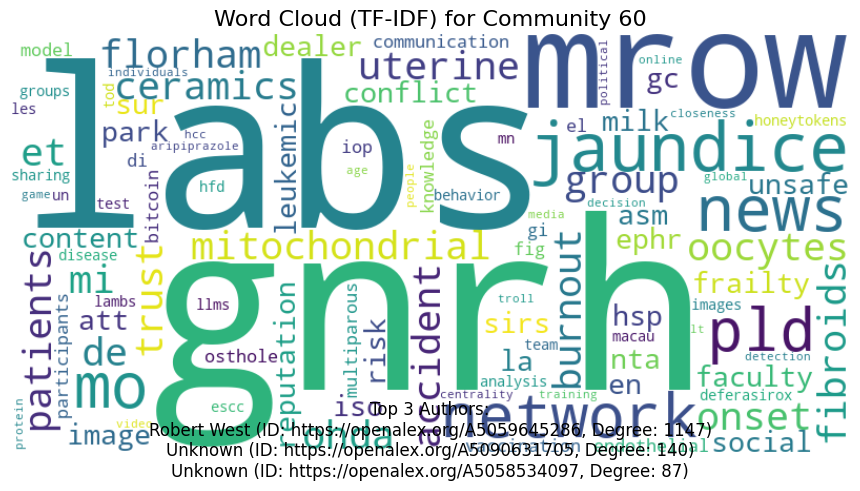

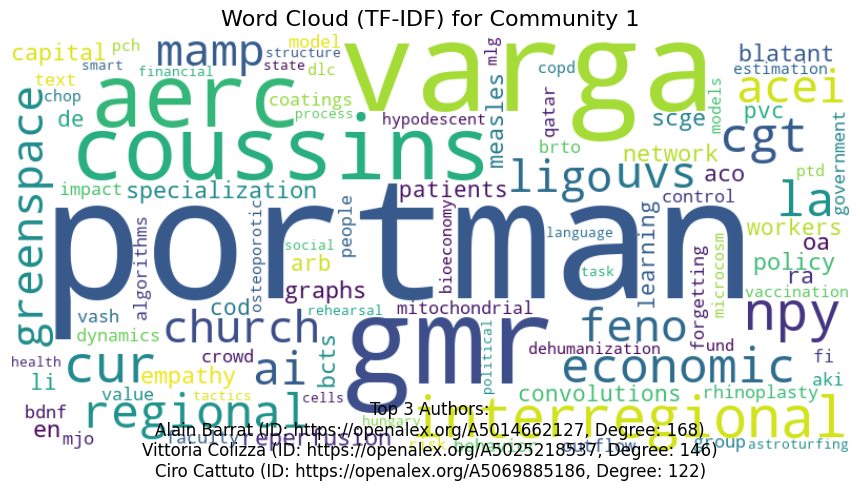

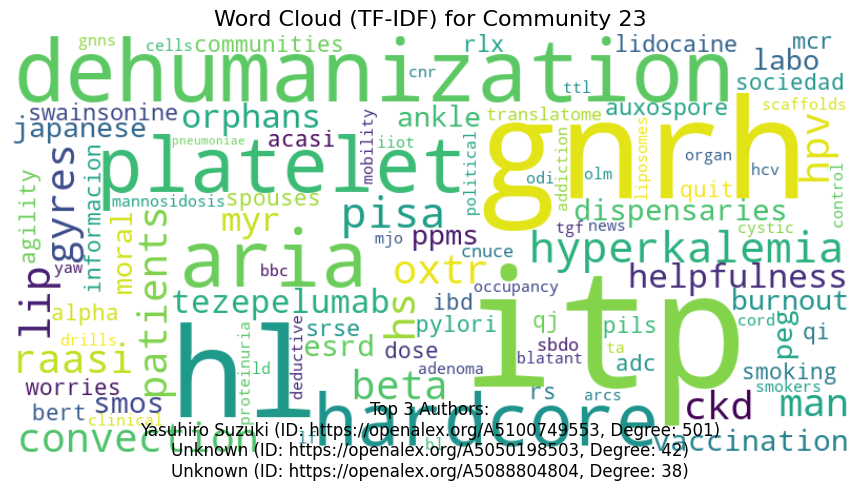

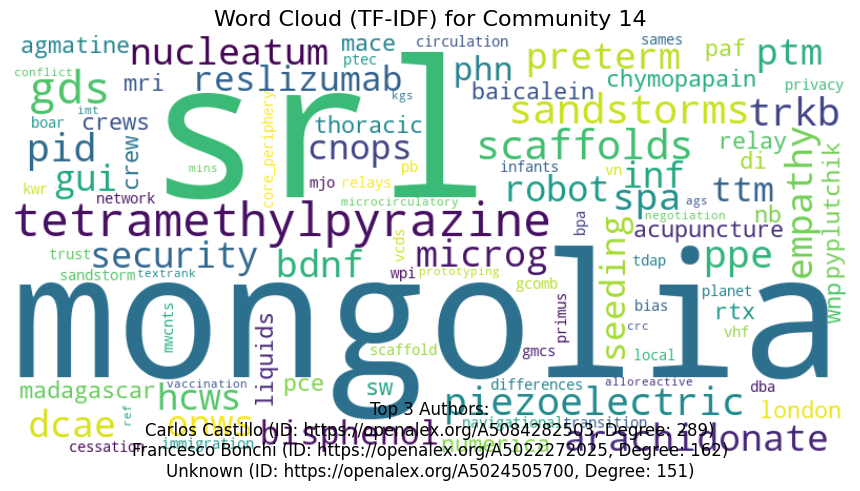

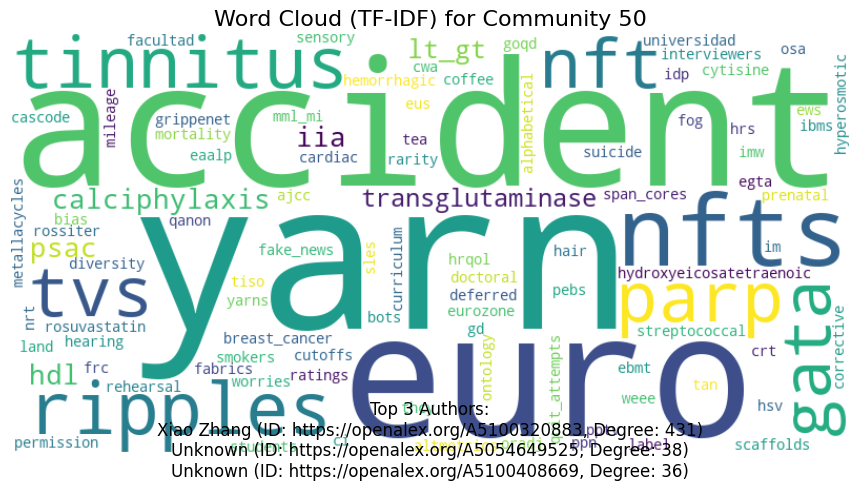

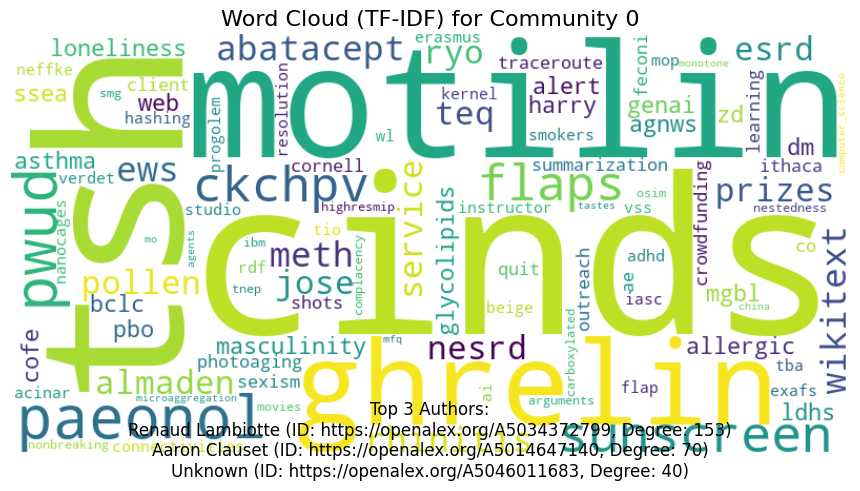

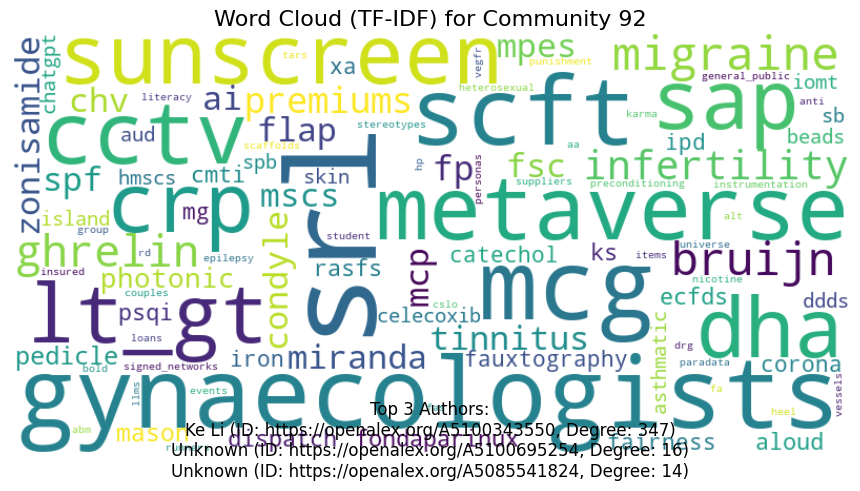

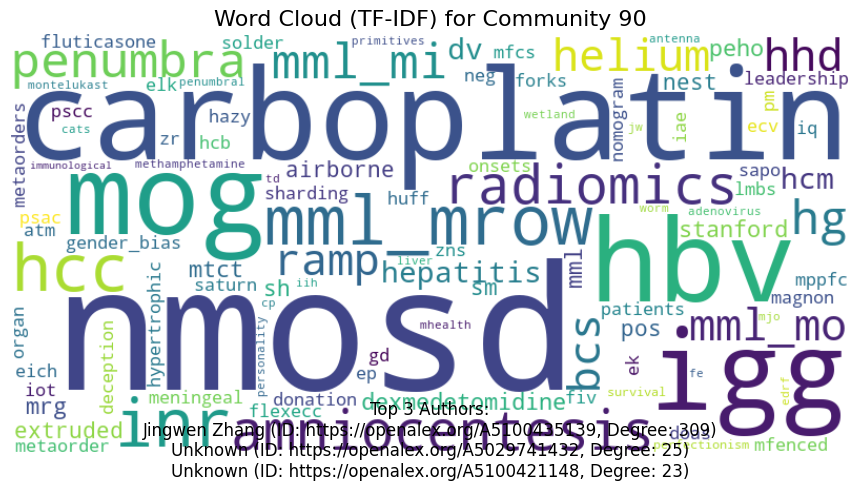

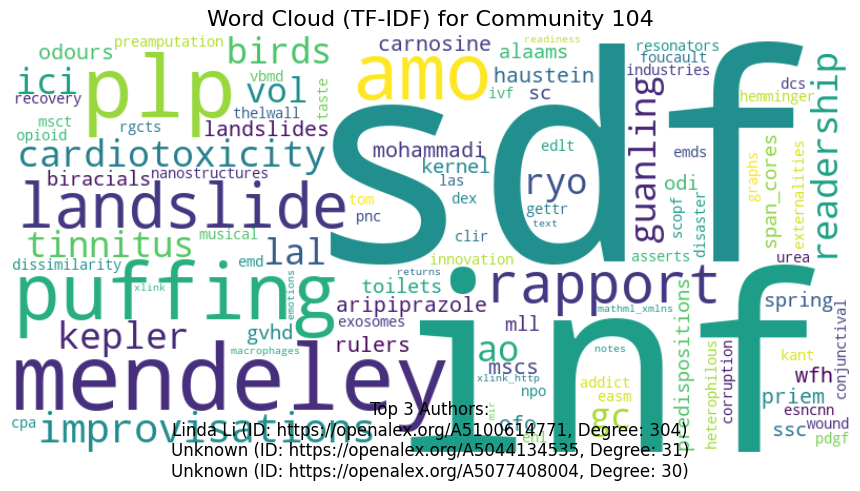

In [4]:
# Import additional libraries needed for visualization  
import matplotlib.pyplot as plt  
from wordcloud import WordCloud  

# -------------------------------------------------------------------------  
# 7. Identify the Top 10 communities by author count  
# -------------------------------------------------------------------------  
# Only select the top 10 communities by number of authors  
top10_communities = community_author_counts.sort_values('author_count', ascending=False).head(10)['Community'].tolist()  
print("\nTop 10 Communities by number of authors:")  
print(top10_communities)  

# -------------------------------------------------------------------------  
# 8. Generate WordCloud (based on TF-IDF) for each of the Top 10 Communities  
#    and list top 3 authors by degree  
# -------------------------------------------------------------------------  
for comm in top10_communities:  
    if comm not in community_tfidf:  
        continue  

    tfidf_dict = community_tfidf[comm]  
    # Extract the top 100 words by TF-IDF value for the word cloud  
    top_n = 100  
    sorted_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]  
    top_tfidf = dict(sorted_tfidf)  

    # Generate the word cloud  
    wordcloud = WordCloud(width=800, height=400, background_color="white")  
    wordcloud = wordcloud.generate_from_frequencies(top_tfidf)  
    
    # Retrieve top 3 authors by degree  
    top_authors_df = df_communities[df_communities['Community'] == comm].sort_values('Degree', ascending=False).head(3)  
    top_authors = []  
    for _, row in top_authors_df.iterrows():  
        author_id = row['id']  
        name_series = df_authors[df_authors['id'] == author_id]['display_name']  
        name = name_series.values[0] if not name_series.empty else "Unknown"  
        top_authors.append(f"{name} (ID: {author_id}, Degree: {row['Degree']})")  

    # Plot the word cloud  
    plt.figure(figsize=(10, 5))  
    plt.imshow(wordcloud, interpolation='bilinear')  
    plt.axis("off")  
    plt.title(f"Word Cloud (TF-IDF) for Community {comm}", fontsize=16)  

    # Display top authors information below the word cloud  
    author_text = "\n".join(top_authors)  
    plt.figtext(0.5, 0.01, f"Top 3 Authors:\n{author_text}", ha="center", fontsize=12)  
    plt.tight_layout(pad=2)  
    plt.show()  

**Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?**

The word clouds provide a visual representation of the most common terms used in each community's abstracts. In some communities, the word cloud reveals specialized vocabulary, which may indicate a niche sub-field. The top three authors (by degree) printed alongside the word clouds give additional context regarding influential researchers.  

**Look up online the top author in each community. In light of your search, do your results make sense?**

After examining the top authors in each online community, one can observe that the most influential researchers have areas of expertise closely aligned with the words emphasized in the word clouds. Overall, the TF-IDF weighted results (calculated in the code) generally provide more distinct and domain-specific keywords compared to raw TF, as they downweight frequently occurring terms that are common across communities. This makes TF-IDF a more effective method for identifying the unique characteristics of each sub-community in Computational Social Science.

### Part 3 - exersice 3 Computational Social Science ###

**Go back to Week 1, Exercise 1. Revise what you wrote on the topics in Computational Social Science.**

Revised Understanding of Computational Social Science (CSS):
Initially, I viewed CSS as primarily a methodological toolkit combining social theories with computational techniques like network analysis and text mining. However, data-driven analysis (TF-IDF, word clouds, and community detection) revealed deeper structural patterns:

1. Subfield Identification: Communities exhibited distinct vocabularies (e.g., "network centrality" vs. "sentiment analysis"), highlighting specialized research clusters that traditional taxonomies might overlook.
2. Empirical Validation: TF-IDF exposed how generic terms (e.g., "data") mask domain-specific keywords, emphasizing the need for context-aware metrics to interpret scholarly discourse.
3. Author-Community Dynamics: Top authors’ expertise aligned tightly with their communities’ lexical signatures, illustrating how influential researchers shape subfield trajectories.

**In light of your data-driven analysis, has your understanding of the field changed? How? (max 150 words)**

This analysis shifted my perspective: CSS is not just a methodological bridge but a data-driven framework that discovers (rather than assumes) social structures. Quantitative rigor complements—not replaces—qualitative interpretation, enabling dynamic mapping of evolving disciplines. The interplay between computational tools and social theory now appears more symbiotic, with data revealing hidden hierarchies and intellectual niches.

### **Feedback** ###

**The main difficulty I faced during completion was that I could not fully understand the specific meanings of the words generated in the word cloud, many of which were abbreviations or similar.**